In [37]:
import os
import pandas as pd
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

dataset_location = '../SRPBS_OPEN/' # made a hard link to the dataset here
np.random.seed(1) # for reproducible random sampling

In [2]:
participants = pd.read_table(dataset_location+'participants.tsv')
participants

,participant_id,site,protocol,diag,age,sex,hand,sup
0,sub-0001,SWA,1,0,23,1,1.0,1
1,sub-0002,SWA,1,0,23,2,1.0,1
2,sub-0003,SWA,1,0,26,1,1.0,1
3,sub-0004,SWA,1,0,23,1,1.0,1
4,sub-0005,SWA,1,0,24,1,1.0,1
...,...,...,...,...,...,...,...,...
1405,sub-1406,CIN,14,5,36,1,1.0,8
1406,sub-1407,CIN,14,5,56,2,1.0,8
1407,sub-1408,CIN,14,5,34,2,1.0,8
1408,sub-1409,CIN,14,5,56,1,1.0,8


In [24]:
participants = participants.dropna()
participants

,participant_id,site,protocol,diag,age,sex,hand,sup
0,sub-0001,SWA,1,0,23,1,1.0,1
1,sub-0002,SWA,1,0,23,2,1.0,1
2,sub-0003,SWA,1,0,26,1,1.0,1
3,sub-0004,SWA,1,0,23,1,1.0,1
4,sub-0005,SWA,1,0,24,1,1.0,1
...,...,...,...,...,...,...,...,...
1405,sub-1406,CIN,14,5,36,1,1.0,8
1406,sub-1407,CIN,14,5,56,2,1.0,8
1407,sub-1408,CIN,14,5,34,2,1.0,8
1408,sub-1409,CIN,14,5,56,1,1.0,8


In [25]:
healthy_controls = participants[participants['diag'] == 0]
mdd_patients = participants[participants['diag'] == 2]

In [26]:
mdd_patients['site'].value_counts()

COI    71
UTO    59
HUH    57
HKH    33
HRC    16
KUT    16
Name: site, dtype: int64

In [27]:
healthy_controls['site'].value_counts()

KUT    159
COI    124
SWA    101
UTO     96
KTT     75
HUH     67
HRC     49
ATV     39
CIN     39
HKH     29
ATT     13
Name: site, dtype: int64

In [19]:
sites_in_common = set(mdd_patients.site).intersection(set(healthy_controls.site))

In [20]:
def match_sample(sample1: pd.DataFrame, sample2: pd.DataFrame):
    age_cost = abs(sample1['age'].to_numpy().reshape(-1,1) - sample2['age'].to_numpy())
    sex_cost = 10*abs(sample1['sex'].to_numpy().reshape(-1,1) - sample2['sex'].to_numpy())
    hand_cost = 5*abs(sample1['hand'].to_numpy().reshape(-1,1) - sample2['hand'].to_numpy())
    cost_matrix = age_cost + sex_cost + hand_cost

    row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_matrix)
    costs = cost_matrix[row_ind, col_ind]
    
    sorted_order = np.argsort(costs)
    return [[sample1.iloc[row],sample2.iloc[col]] for row, col in zip(row_ind[sorted_order], col_ind[sorted_order])], costs.sum(), costs[sorted_order]

In [21]:
def write_pairs(pairs, site: str):
    pair_ids = [[int(pair[0].participant_id.split('-')[1]), int(pair[1].participant_id.split('-')[1])] for pair in pairs]
    with open(f'{site}_pairs.txt','w') as f:
        f.write(str(pair_ids))

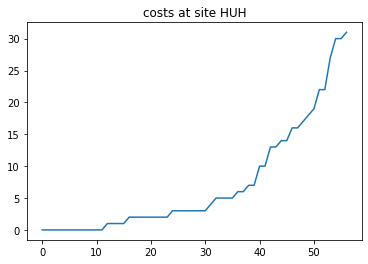

12/57 perfect pairs out of at site HUH


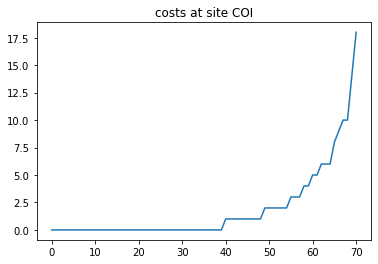

40/71 perfect pairs out of at site COI


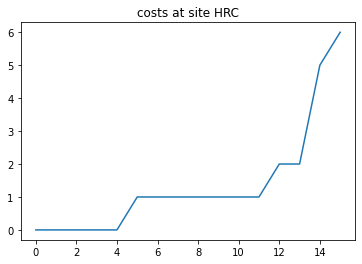

5/16 perfect pairs out of at site HRC


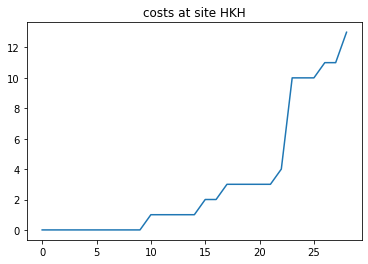

10/29 perfect pairs out of at site HKH


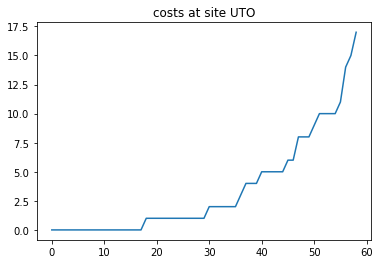

18/59 perfect pairs out of at site UTO


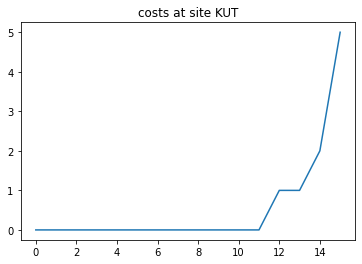

12/16 perfect pairs out of at site KUT


In [51]:
for site in sites_in_common:
    healthy_controls_at_site = healthy_controls[healthy_controls.site == site]
    mdd_patients_at_site = mdd_patients[mdd_patients.site == site]
    matched_pairs, total_cost, sorted_costs = match_sample(healthy_controls_at_site, mdd_patients_at_site)
    plt.plot(sorted_costs)
    plt.title(f'costs at site {site}')
    plt.show()
    print(f'{np.sum(sorted_costs == 0)}/{min(healthy_controls_at_site.shape[0],mdd_patients_at_site.shape[0])} perfect pairs out of at site {site}')
    write_pairs(matched_pairs, site)

    perfect_pairs = [matched_pair for matched_pair, cost in zip(matched_pairs,sorted_costs) if cost == 0]
    write_pairs(perfect_pairs, site+'_perfectpair')